# Resampling Methods - Chapter Figures

This notebook reproduces key figures from Chapter 5 (Resampling Methods) of Introduction to Statistical Learning.

## Setup and Imports

In [1]:
import numpy as np
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import ModelSpec as MS, poly
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

## Load Data

In [2]:
# Load the Auto dataset
auto = load_data('Auto')
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1


## Figure 5.2: The Validation Set Approach

This figure shows the variability in MSE estimates when using the validation set approach with different random splits.

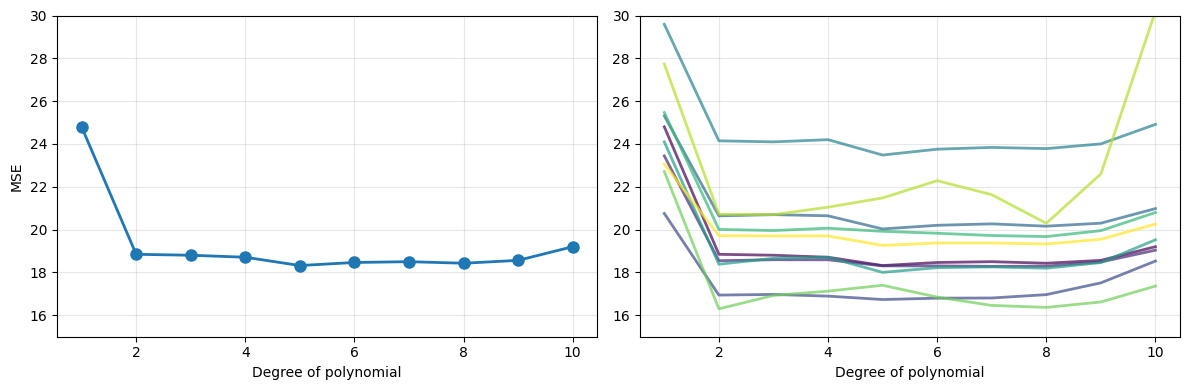

Figure 5.2: Validation Set Approach - showing variability across different splits


In [3]:
def evaluate_poly_validation(X, y, poly_degrees, seed):
    """Evaluate polynomial models using validation set approach"""
    np.random.seed(seed)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=seed)
    
    mse_values = []
    for degree in poly_degrees:
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_train_poly = poly.fit_transform(X_train.reshape(-1, 1))
        X_val_poly = poly.transform(X_val.reshape(-1, 1))
        
        # Fit linear regression
        model = LinearRegression()
        model.fit(X_train_poly, y_train)
        
        # Predict and compute MSE
        y_pred = model.predict(X_val_poly)
        mse = mean_squared_error(y_val, y_pred)
        mse_values.append(mse)
    
    return mse_values

# Prepare data
X = auto['horsepower'].values
y = auto['mpg'].values
poly_degrees = range(1, 11)

# Run validation set approach with 10 different seeds
results = {}
for i in range(1, 11):
    results[i] = evaluate_poly_validation(X, y, poly_degrees, seed=i)

# Create Figure 5.2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Left panel: Single run
ax1.plot(poly_degrees, results[1], 'o-', linewidth=2, markersize=8)
ax1.set_xlabel('Degree of polynomial')
ax1.set_ylabel('MSE')
ax1.set_ylim(15, 30)
ax1.set_xticks([2, 4, 6, 8, 10])
ax1.grid(True, alpha=0.3)

# Right panel: Multiple runs
colors = plt.cm.viridis(np.linspace(0, 1, 10))
for i, (rep, mse_vals) in enumerate(results.items()):
    ax2.plot(poly_degrees, mse_vals, '-', linewidth=2, color=colors[i], alpha=0.7)
ax2.set_xlabel('Degree of polynomial')
ax2.set_ylim(15, 30)
ax2.set_xticks([2, 4, 6, 8, 10])
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figure_5_2.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure 5.2: Validation Set Approach - showing variability across different splits")

## Figure 5.4: 10-Fold Cross-Validation

This figure demonstrates that k-fold cross-validation has less variability than the validation set approach.

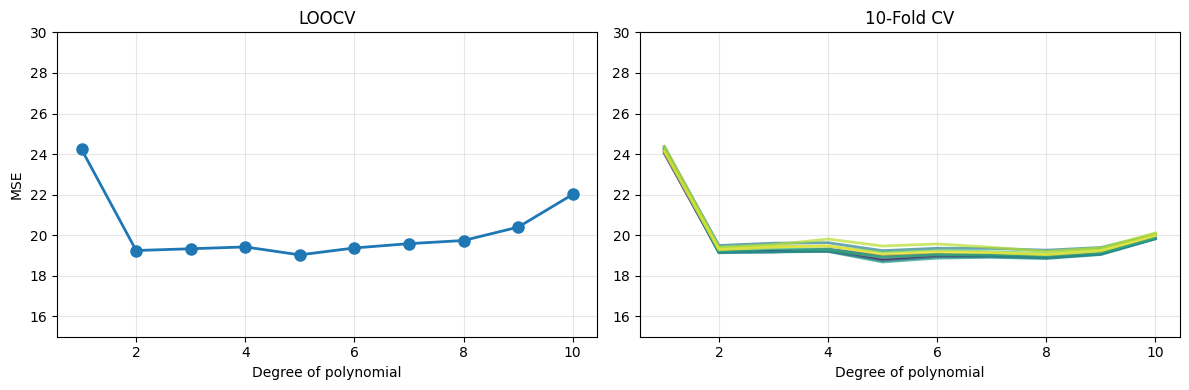

Figure 5.4: k-Fold Cross-Validation - showing less variability than validation set approach


In [4]:
def evaluate_poly_kfold(X, y, poly_degrees, seed, k=10):
    """Evaluate polynomial models using k-fold cross-validation"""
    np.random.seed(seed)
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    
    mse_values = []
    for degree in poly_degrees:
        fold_mses = []
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            # Create polynomial features
            poly = PolynomialFeatures(degree=degree, include_bias=False)
            X_train_poly = poly.fit_transform(X_train.reshape(-1, 1))
            X_val_poly = poly.transform(X_val.reshape(-1, 1))
            
            # Fit and predict
            model = LinearRegression()
            model.fit(X_train_poly, y_train)
            y_pred = model.predict(X_val_poly)
            
            fold_mses.append(mean_squared_error(y_val, y_pred))
        
        mse_values.append(np.mean(fold_mses))
    
    return mse_values

# LOOCV estimate (for left panel)
def loocv_estimate(X, y, poly_degrees):
    """Compute LOOCV estimate using shortcut formula for linear models"""
    n = len(X)
    mse_values = []
    
    for degree in poly_degrees:
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_poly = poly.fit_transform(X.reshape(-1, 1))
        
        # Add intercept
        X_with_intercept = np.column_stack([np.ones(n), X_poly])
        
        # Fit model
        model = LinearRegression()
        model.fit(X_poly, y)
        y_pred = model.predict(X_poly)
        
        # Compute hat matrix diagonal
        H = X_with_intercept @ np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T
        h = np.diag(H)
        
        # LOOCV formula
        residuals = y - y_pred
        loocv_mse = np.mean((residuals / (1 - h)) ** 2)
        mse_values.append(loocv_mse)
    
    return mse_values

# Get LOOCV estimate
loocv_mse = loocv_estimate(X, y, poly_degrees)

# Run 10-fold CV with different seeds
kfold_results = {}
for i in range(1, 11):
    kfold_results[i] = evaluate_poly_kfold(X, y, poly_degrees, seed=i)

# Create Figure 5.4
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Left panel: LOOCV
ax1.plot(poly_degrees, loocv_mse, 'o-', linewidth=2, markersize=8)
ax1.set_xlabel('Degree of polynomial')
ax1.set_ylabel('MSE')
ax1.set_ylim(15, 30)
ax1.set_xticks([2, 4, 6, 8, 10])
ax1.grid(True, alpha=0.3)
ax1.set_title('LOOCV')

# Right panel: 10-fold CV with multiple runs
colors = plt.cm.viridis(np.linspace(0, 1, 10))
for i, (rep, mse_vals) in enumerate(kfold_results.items()):
    ax2.plot(poly_degrees, mse_vals, '-', linewidth=2, color=colors[i], alpha=0.7)
ax2.set_xlabel('Degree of polynomial')
ax2.set_ylim(15, 30)
ax2.set_xticks([2, 4, 6, 8, 10])
ax2.grid(True, alpha=0.3)
ax2.set_title('10-Fold CV')

plt.tight_layout()
plt.savefig('figure_5_4.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure 5.4: k-Fold Cross-Validation - showing less variability than validation set approach")

## Figure 5.9: Bootstrap - Simulated Data

Four simulated datasets showing the relationship between X and Y for estimating the optimal investment fraction alpha.

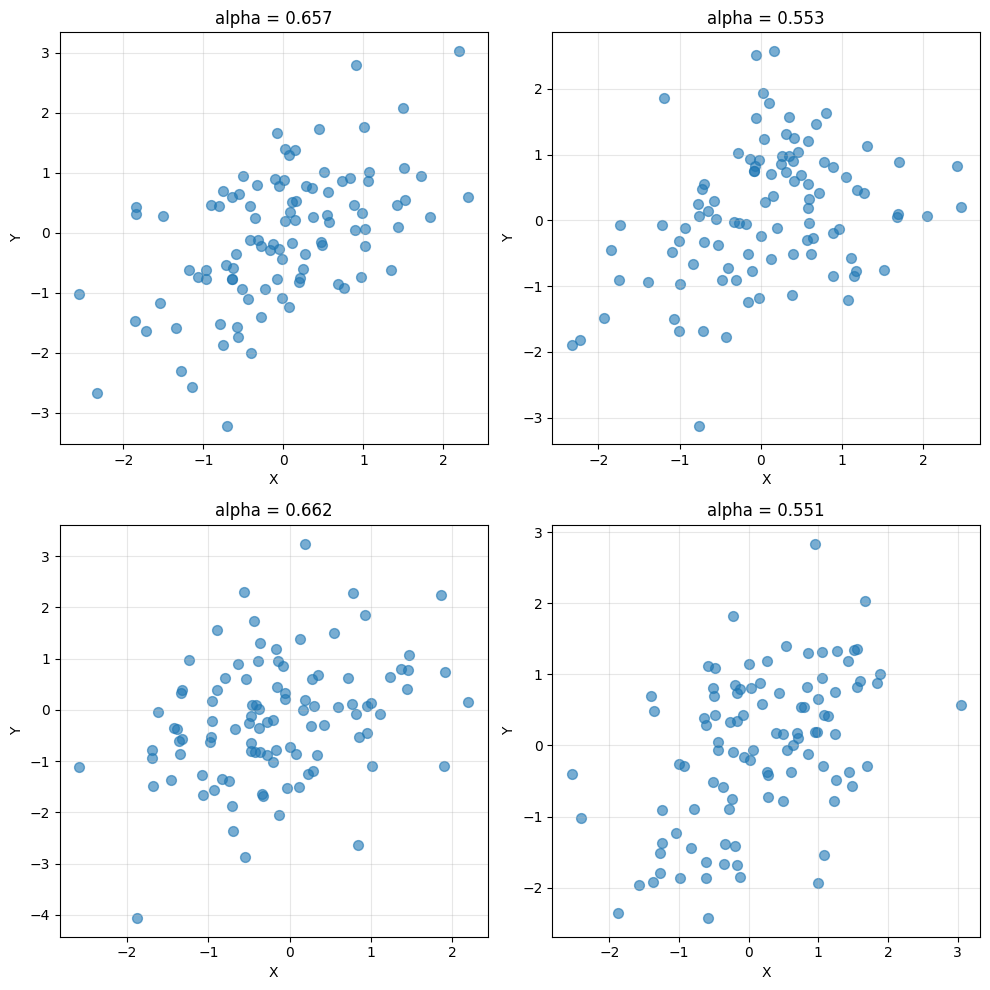

Figure 5.9: Four simulated datasets for bootstrap estimation of alpha


In [5]:
def compute_alpha(x, y):
    """Compute the optimal alpha for investment allocation"""
    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)
    cov_xy = np.cov(x, y)[0, 1]
    alpha = (var_y - cov_xy) / (var_x + var_y - 2 * cov_xy)
    return alpha

# Set parameters for bivariate normal
sigma_x = 1.0
sigma_y = np.sqrt(1.25)
sigma_xy = 0.5

# Covariance matrix
cov_matrix = np.array([[sigma_x**2, sigma_xy],
                       [sigma_xy, sigma_y**2]])

# Generate 4 simulated datasets
np.random.seed(319)
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

simulated_data = []
for i in range(4):
    # Generate 100 observations from bivariate normal
    data = np.random.multivariate_normal([0, 0], cov_matrix, 100)
    x, y = data[:, 0], data[:, 1]
    alpha = compute_alpha(x, y)
    simulated_data.append((x, y, alpha))
    
    # Plot
    axes[i].scatter(x, y, alpha=0.6, s=50)
    axes[i].set_xlabel('X')
    axes[i].set_ylabel('Y')
    axes[i].set_title(f'alpha = {alpha:.3f}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figure_5_9.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure 5.9: Four simulated datasets for bootstrap estimation of alpha")

## Figure 5.10: Bootstrap Distribution vs True Distribution

Comparison of bootstrap resampling estimates with the true population distribution.

/tmp/ipykernel_3496/1737244100.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot([true_alphas, bootstrap_alphas],


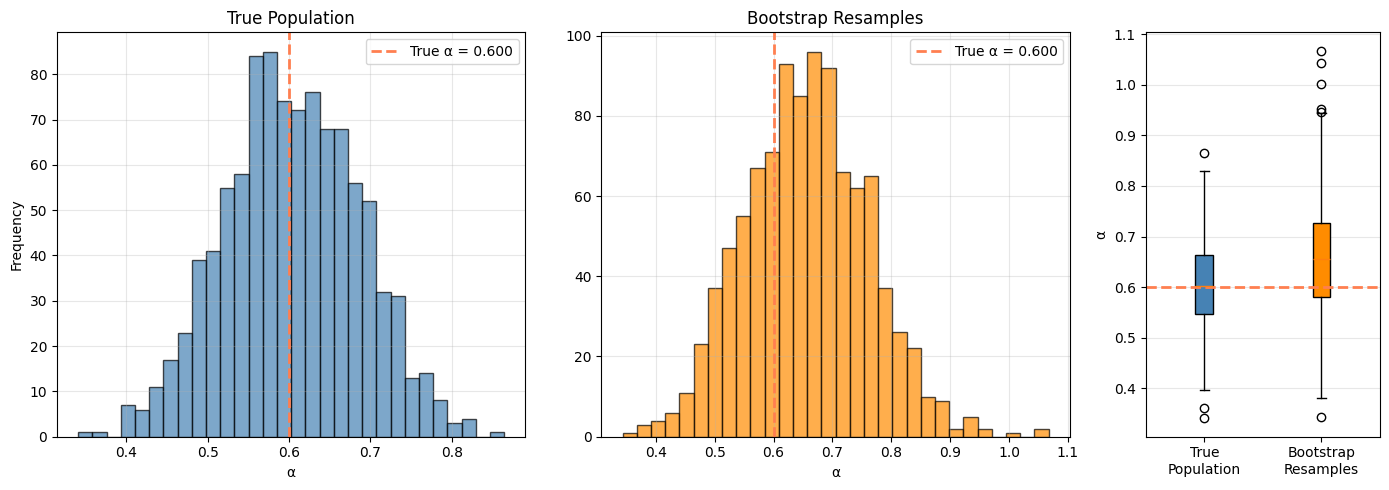

Figure 5.10: Bootstrap vs True Distribution
True alpha: 0.6000

True population - Mean: 0.6038, SE: 0.0830
Bootstrap - Mean: 0.6559, SE: 0.1046


In [6]:
# True alpha
true_alpha = (sigma_y**2 - sigma_xy) / (sigma_x**2 + sigma_y**2 - 2 * sigma_xy)

# Generate 1000 datasets from true population
np.random.seed(1)
true_alphas = []
for _ in range(1000):
    data = np.random.multivariate_normal([0, 0], cov_matrix, 100)
    x, y = data[:, 0], data[:, 1]
    true_alphas.append(compute_alpha(x, y))

# Bootstrap resampling from the first simulated dataset
x1, y1, _ = simulated_data[0]
bootstrap_alphas = []
np.random.seed(1)
for _ in range(1000):
    # Resample with replacement
    indices = np.random.choice(len(x1), size=len(x1), replace=True)
    x_boot = x1[indices]
    y_boot = y1[indices]
    bootstrap_alphas.append(compute_alpha(x_boot, y_boot))

# Create Figure 5.10
fig = plt.figure(figsize=(14, 5))
gs = fig.add_gridspec(1, 3, width_ratios=[2, 2, 1])

# Left: Histogram of true population alphas
ax1 = fig.add_subplot(gs[0])
ax1.hist(true_alphas, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(true_alpha, color='coral', linewidth=2, linestyle='--', label=f'True α = {true_alpha:.3f}')
ax1.set_xlabel('α')
ax1.set_ylabel('Frequency')
ax1.set_title('True Population')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Middle: Histogram of bootstrap alphas
ax2 = fig.add_subplot(gs[1])
ax2.hist(bootstrap_alphas, bins=30, alpha=0.7, color='darkorange', edgecolor='black')
ax2.axvline(true_alpha, color='coral', linewidth=2, linestyle='--', label=f'True α = {true_alpha:.3f}')
ax2.set_xlabel('α')
ax2.set_title('Bootstrap Resamples')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Right: Boxplots
ax3 = fig.add_subplot(gs[2])
bp = ax3.boxplot([true_alphas, bootstrap_alphas], 
                  labels=['True\nPopulation', 'Bootstrap\nResamples'],
                  patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][1].set_facecolor('darkorange')
ax3.axhline(true_alpha, color='coral', linewidth=2, linestyle='--')
ax3.set_ylabel('α')
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figure_5_10.png', dpi=150, bbox_inches='tight')
plt.show()

# Print statistics
print("Figure 5.10: Bootstrap vs True Distribution")
print(f"True alpha: {true_alpha:.4f}")
print(f"\nTrue population - Mean: {np.mean(true_alphas):.4f}, SE: {np.std(true_alphas):.4f}")
print(f"Bootstrap - Mean: {np.mean(bootstrap_alphas):.4f}, SE: {np.std(bootstrap_alphas):.4f}")

## Summary

This notebook has reproduced the key figures from Chapter 5:

- **Figure 5.2**: Demonstrates the high variability of the validation set approach
- **Figure 5.4**: Shows that k-fold cross-validation has lower variability than validation set approach
- **Figure 5.9**: Illustrates four simulated datasets for bootstrap analysis
- **Figure 5.10**: Compares bootstrap resampling distribution with the true population distribution

All figures have been saved as PNG files.